## Introduction

Within the world of data science, Keras's deep learning applications have found uses across a multitude of domains from finance and business, to even healthcare and sports. By introducing these complex pattern recognition algorithms, data scientists have been able to find ways to solve many specific problems that were previously unreasonable to achieve with computers and code.  In this example walkthrough, we are going to discuss a serious yet powerful application, to use deep-learning and `Image Classification`, to predict if an individuals MRI brain scan, contains signs of Cancer in the form of a tumor.

Obviously, hospitals and research facilities can utilize the fast speed and ease of these models without meticulously sorting through every image. However, this application requires extreme precautions and ensures that our model is highly accurate, with close monitoring of any negative predictions to avoid false positives. Even in this scenario, a model can help flag individuals at risk or with small tumors before a doctor might, and even detect signs common among other cancer patients that may not be noticed by humans.  This application focuses on the health benefits that can be derived through machine learning, rather than a direct business case which would come as indirect positives.

### Data Preparation & Context

To carry out this image classification problem, we first have to load our images into Python and prepare our dataset for modeling. To do this, we specify two directory paths pointing to folder's on my local computer containing our 5,712 Training and 1,311 Testing images.  For more context, all images came from 3 different sources of MRI scan's in which they were labeled by the type of brain cancer the patient has, ranging from `no tumor`, `glioma`, `meningioma`, and `pituitary`.  The distinctions between these stages can be better distinguished by medical professionals in the following way:


- **Glioma**: Often the most serious, gliomas are tumors arising from glial cells in the brain and spinal cord, with a potential for malignancy and rapid progression.
- **Meningioma**: Generally less serious than gliomas, meningiomas are usually benign tumors that develop from the meninges but can cause significant problems due to their location.
- **Pituitary Tumor**: Generally the least serious, pituitary tumors are usually benign growths in the pituitary gland that can cause hormonal imbalances.
- **No Tumor**: Indicates normal brain scans with no signs of tumors, posing no immediate concern for cancer.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Directories
train_dir = '/Users/rileysvensson/Desktop/GSB 545 - Advanced Machine Learning/archive (7)/Training'
test_dir = '/Users/rileysvensson/Desktop/GSB 545 - Advanced Machine Learning/archive (7)/Testing'

Following this path specification, we use the `ImageDataGenerator` class in Keras is used to transform our images into numerical arrays, making them suitable for training a neural network. By specifying the directories for training, validation, and test datasets, the ImageDataGenerator can automatically load images, apply transformations, and convert them into batches of numerical arrays digestible for our neural network. Using the `flow_from_directory` method, we create generators for the training, validation, and test sets, with images resized to 150x150 pixels and grouped into batches of 32. This setup results in three sets of images: 4571 for training, 1141 for validation (20% of 5,712), and 1311 for testing, each belonging to one of our four named classes which are used to display a few examples our labeled images in the next step: glioma, meningioma, pituitary, and no tumor.

In [2]:
# Class names
CLASS_NAMES = ['glioma', 'meningioma', 'no tumor', 'pituitary']

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


#### Sanity Check #1: Visualize Training Images 

Using a custom function, we can visualize a few training images to ensure that the data augmentation and preprocessing steps are correctly applied, and double-check that our labels are correctly mapped which is easy to confirm with a no tumor case. Behind the scenes, `display_images`, we are taking a batch of images and labels from any specified data generator and then displaying the specified number of images in a row (5), along with their corresponding labels. This visual sanity check ensures that the images are correctly augmented and labeled, providing confidence that the data preparation steps are functioning properly.

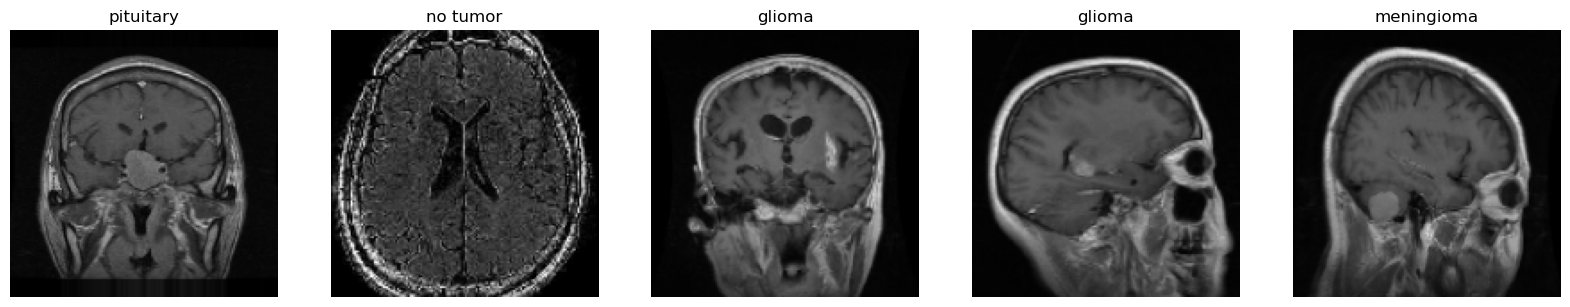

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def display_images(generator, num_images):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img)
        ax.set_title(CLASS_NAMES[np.argmax(label)])
        ax.axis('off')
    plt.show()

# Display 5 images from the training set
display_images(train_generator, 5)

## Modeling & Evaluation

To build and evaluate our neural network model, we start by defining the model architecture using Keras' Sequential API. The sequential step allows us to stack layers in a linear order, making it straightforward to build and visualize the model's structure. Overall, this model is a `Convolutional Neural Network (CNN)` designed for image classification, which consists of several convolutional layers with ReLU activation functions to detect and learn various features from the images, followed by max-pooling layers to reduce the spatial dimensions and computational complexity while preserving important features. We also include dropout layers to prevent overfitting which randomly set a % of input units to zero at each update during training, to promote more robust feature learning.  Lastly the final layer is a dense layer with a softmax activation function to classify the images into one of the four categories: glioma, meningioma, no tumor, and pituitary.  To view a visual representation of our model's architecture, we can leverage the following line of code, model.summary().

In [6]:
from tensorflow.keras import layers, models

# Model building
model = models.Sequential([
    layers.InputLayer(shape=(150, 150, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 classes for the 4 tumor types
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Training
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

# Evaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,943,812 (26.49 MB)

 Trainable params: 6,943,812 (26.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 232ms/step - accuracy: 0.3984 - loss: 1.2163 - val_accuracy: 0.6354 - val_loss: 1.0303
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 227ms/step - accuracy: 0.6987 - loss: 0.7262 - val_accuracy: 0.6889 - val_loss: 0.9064
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 230ms/step - accuracy: 0.7546 - loss: 0.5995 - val_accuracy: 0.6994 - val_loss: 0.8256
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 231ms/step - accuracy: 0.8165 - loss: 0.4671 - val_accuracy: 0.7195 - val_loss: 0.7378
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 227ms/step - accuracy: 0.8510 - loss: 0.4082 - val_accuracy: 0.7581 - val_loss: 0.6590
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 231ms/step - accuracy: 0.8758 - loss: 0.3298 - val_accuracy: 0.7537 - val_loss: 0.6668
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 229ms/step - accuracy: 0.8856 - loss: 0.3185 - val_accuracy: 0.7958 - val_loss: 0.5629
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 226ms/step - accuracy: 0.9034 - loss: 0

### Discussion of Metrics:

In this model, we use `categorical_crossentropy` to measure our loss (or error) because we are dealing with a multi-class classification problem, where we aim to classify images into one of four categories: glioma, meningioma, no tumor, and pituitary. The optimizing function used is Adam, which is an efficient gradient descent algorithm. The key metric we initially focused on is accuracy, which tells us the proportion of correctly classified images. In this case, our model achieved a test accuracy of approximately 93%, meaning that the model correctly identifies the type of brain tumor (or no tumor) in 93% of the images when applied to unseen images.

However, in medical diagnostics, it is crucial to minimize false negatives, where a tumor is present but the model fails to detect it. Therefore, we also evaluate precision, recall, and F1 score for a more comprehensive assessment of the model's performance. Recall also known as sensitivity, is particularly important as it indicates the model's ability to correctly identify all actual positive cases, which in this context is detecting tumors when they are present.

In [15]:
from sklearn.metrics import classification_report

# Get the true labels and predictions
y_true = []
y_pred = []

# Suppress verbose output by using `predict` directly without printing each step
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(model.predict(x_batch, verbose=0), axis=1))  # Set verbose=0 to suppress output

# Print classification report
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


              precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       300
  meningioma       0.91      0.82      0.86       306
    no tumor       0.88      0.99      0.93       405
   pituitary       0.97      0.98      0.97       300

    accuracy                           0.93      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



The classification report provides detailed metrics for each class. For instance, the recall for the "no tumor" class is 0.99, indicating that the model is highly effective at correctly identifying cases where no tumor is present, while the recall for "meningioma" is 0.82, suggesting there is room for improvement in detecting this tumor type.  By analyzing precision, recall, and F1 score alongside accuracy, we can ensure our model not only performs well overall but also minimizes the risk of false negatives, thereby providing more reliable diagnostic support in a real-world medical setting.

### Behind the Scenes: Prediction Example

This final chunk of code provides a detailed look at how the model actually makes predictions on individual images from the test set. By displaying the image and showing the true and predicted labels, we can visually confirm the model's performance on any specific case. The prediction scores are derived from the softmax layer, which converts the raw output of the network into probabilities for each class, and ensures that they sum up to 100%.

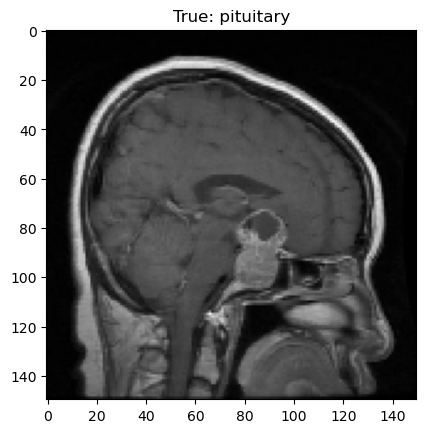

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
This image is 0.21 percent glioma
This image is 2.56 percent meningioma
This image is 0.01 percent no tumor
This image is 97.22 percent pituitary

 Predicted: pituitary


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming class names are as follows:
CLASS_NAMES = ['glioma', 'meningioma', 'no tumor', 'pituitary']

# Get one example from the test set
for image_batch, label_batch in test_generator:
    image = image_batch[0]
    true_label = label_batch[0]
    
    # Display the image
    plt.imshow(image)
    plt.title(f"True: {CLASS_NAMES[np.argmax(true_label)]}")
    plt.show()
    
    # Make a prediction
    prediction = model.predict(np.expand_dims(image, axis=0))[0]
    scores = {name: score for name, score in zip(CLASS_NAMES, prediction)}
    
    # Print the prediction scores
    for name, score in scores.items():
        print(f"This image is {score * 100:.2f} percent {name}")
    
    # Print the predicted label
    predicted_label = CLASS_NAMES[np.argmax(prediction)]
    print(f"\n Predicted: {predicted_label}")
    
    # Break after one example image application
    break

In this example, the model was given an image of a true pituitary tumor. It predicted the image to be a pituitary tumor with a high confidence of 97.22%, while the other prediction scores showing minuscule confidence with 0.21% for glioma, 2.56% for meningioma, and 0.01% confident that it showed no tumor. **This final percentage was important and beneficial to see as our model was 99.99% confident that this patient had a tumor (100-.01), when in fact they did.**  This demonstrates the model's ability to accurately identify the type of brain tumor, with the highest confidence score correctly corresponding to the true label. Such detailed prediction scores help in understanding the model's confidence and decision-making process in specific cases which is crucial in medical diagnostics to ensure reliable and accurate results.

## Conclusion

Achieving 93% overall accuracy, recall, and F1 scores (a tradeoff between precision and recall) indicates that our model is highly effective in distinguishing between different types of brain tumors. While high accuracy and robust performance metrics are essential, the primary goal of this model is not to be used for business profits but to save lives and alleviate the worldwide suffering caused by cancer.

Cancer has a profound impact on many families, including my own, and the ability to accurately diagnose brain tumors can lead to earlier interventions and better treatment outcomes. This application of machine learning has the potential to significantly improve the quality of healthcare by providing doctors with an additional tool to support their diagnoses.  

For practical applications in healthcare, this level of accuracy can lead to numerous benefits. An accurate and reliable model can assist healthcare professionals in making more informed decisions, reducing the likelihood of misdiagnosis and ensuring that patients receive the appropriate treatment as soon as possible. By identifying tumors at an earlier stage, the model can help initiate treatment plans sooner, which can be crucial for patient outcomes, especially in aggressive cancers like gliomas.  Moreover, the model serves as a supplementary tool that can highlight potential areas of concern in MRI scans, allowing radiologists and oncologists to focus their attention on cases that require further examination. Even experienced medical professionals can make mistakes, particularly when under pressure, so having a machine learning model to provide a consistent second opinion, can improve diagnostic confidence.

In summary, the application of this model goes beyond business advantages and profits. It aims to contribute to the healthcare field by enhancing diagnostic accuracy, supporting early detection, and ultimately saving lives. By leveraging the best practices and structures provided by Keras, we can apply this machine learning methodology to make a real, positive impact on people's lives.

## Sources

[Keras Notebook Inspiration - XRay Classification for Pneumonia](https://keras.io/examples/vision/xray_classification_with_tpus/)

[Kaggle Dataset - Brain Tumor MRI Images](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data)